# Introduction to Autoencoder

An Autoencoder is a widely used neural network architecture in deep learning for tasks such as dimensionality reduction, data compression, and anomaly detection. It's a type of unsupervised neural network that has the ability to learn effective representations of input data by discovering patterns and important features within the data. An interesting application of Autoencoders is in anomaly detection, where they can be trained to reconstruct normal data and then identify anomalies based on the difference between input data and the reconstruction.


# Components of an Autoencoder
The Autoencoder consists of three main components:

Encoder:

1. The **encoder** is the part of the neural network responsible for transforming input data into a lower-dimensional latent representation. It performs data compression by capturing important features.
Latent Space:

2. The **latent space** is where the lower-dimensional representation is held. This representation contains essential information about the input data and is the central point of the Autoencoder.
Decoder:

3. The **decoder** is responsible for reconstructing the data from the latent representation. It tries to generate an output that is a close reconstruction of the original input data.

<p align="center">
    <img src="imgs\AutoencoderArch.jpg" alt="AutoEncoder Architecture" width="500"/>
    <p align="center">AutoEncoder Architecture</p>
</p>

# Anomaly Detection with Autoencoder
To detect anomalies using an Autoencoder, the general procedure is as follows:

1. Train the Autoencoder with normal data, i.e., data that does not contain anomalies.

2. Use the trained Autoencoder to reconstruct the input data.

3. Calculate the difference between the input data and the reconstructions.

4. Set a threshold for this difference. Any input that has a difference above this threshold is considered an anomaly.

# Advantages of Autoencoders in Anomaly Detection

* Autoencoders are capable of capturing complex and nonlinear patterns in data, making them effective for detecting anomalies.

* It is an unsupervised approach, meaning it does not require anomaly labels in the training dataset, making it useful when anomalous data is rare or unknown.

* The flexibility of Autoencoders allows adaptation to different types of data and anomaly detection tasks.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.layers import (
    ReLU,
    Dense,
    Activation,
    BatchNormalization,
)

sns.set_style("darkgrid")

In [2]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [3]:
# Download the dataset

df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = df.values

df.head()


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [4]:
# The labels are in the last column
labels = raw_data[:, -1]

# The ECG data
data = raw_data[:, 0:-1]

# Split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [5]:
# Normalize data (values between 0, 1)
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [6]:
# Separete data into Normal data and Anomalous Data (Because the model is training only on Normal data)
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

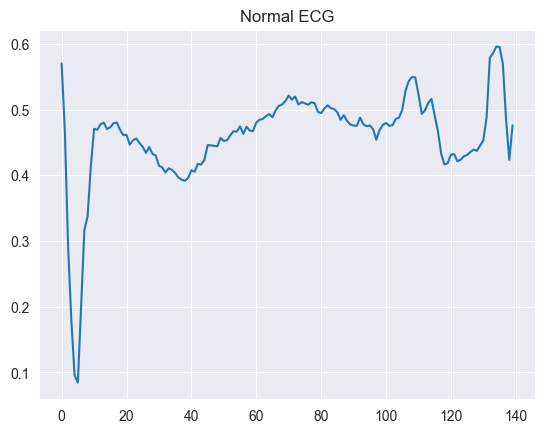

In [7]:
# Plot Normal ECG Data
sns.lineplot(normal_train_data[0])
plt.title("Normal ECG")
plt.show()

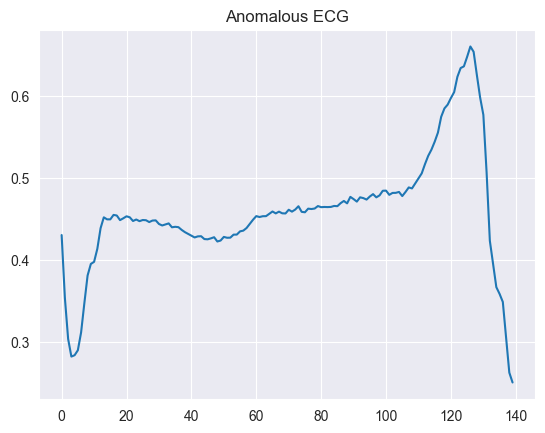

In [8]:
# Plot Anomalous ECG Data
sns.lineplot(anomalous_train_data[0])
plt.title("Anomalous ECG")
plt.show()

### Building the model

In [9]:
class AnomalyDetector(tf.keras.Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()

        self.encoder = self.get_encoder()
        self.decoder = self.get_decoder()

    def get_encoder(self):
        """Return the encoder arch"""
        encoder = tf.keras.models.Sequential([

            Dense(32),
            BatchNormalization(),
            ReLU(),

            Dense(16),
            BatchNormalization(),
            ReLU(),

            Dense(8),
            BatchNormalization(),
            ReLU(),
        ])
        return encoder
    
    def get_decoder(self):
        decoder = tf.keras.models.Sequential([
            Dense(16),
            BatchNormalization(),
            ReLU(),

            Dense(32),
            BatchNormalization(),
            ReLU(),

            Dense(64),
            BatchNormalization(),
            ReLU(),

            Dense(140),
            BatchNormalization(),
            Activation("sigmoid")
        ])
        return decoder
    
    def call(self, ecp_inp):
        encoder = self.encoder(ecp_inp)
        decoder = self.decoder(encoder)
        return decoder

### Training the Model

In [10]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

In [11]:

history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=40, 
          batch_size=256,
          validation_data=(test_data, test_data),
          shuffle=True,)

Epoch 1/40
10/10 [==============================] - 3s 29ms/step - loss: 0.1450 - val_loss: 0.0540
Epoch 2/40
10/10 [==============================] - 0s 6ms/step - loss: 0.1027 - val_loss: 0.0522
Epoch 3/40
10/10 [==============================] - 0s 6ms/step - loss: 0.0775 - val_loss: 0.0504
Epoch 4/40
10/10 [==============================] - 0s 7ms/step - loss: 0.0644 - val_loss: 0.0487
Epoch 5/40
10/10 [==============================] - 0s 6ms/step - loss: 0.0560 - val_loss: 0.0472
Epoch 6/40
10/10 [==============================] - 0s 6ms/step - loss: 0.0510 - val_loss: 0.0457
Epoch 7/40
10/10 [==============================] - 0s 6ms/step - loss: 0.0487 - val_loss: 0.0444
Epoch 8/40
10/10 [==============================] - 0s 6ms/step - loss: 0.0461 - val_loss: 0.0432
Epoch 9/40
10/10 [==============================] - 0s 6ms/step - loss: 0.0451 - val_loss: 0.0421
Epoch 10/40
10/10 [==============================] - 0s 6ms/step - loss: 0.0428 - val_loss: 0.0411
Epoch 11/40
10/10 

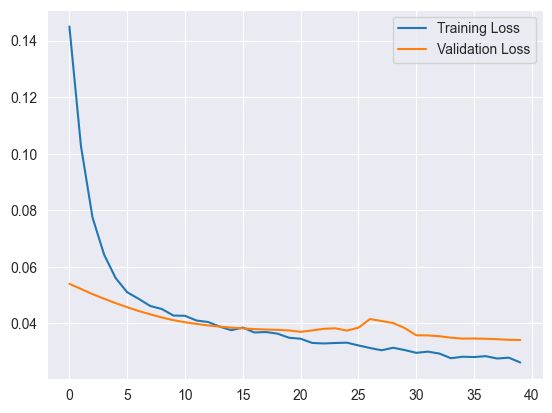

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### Evaluating

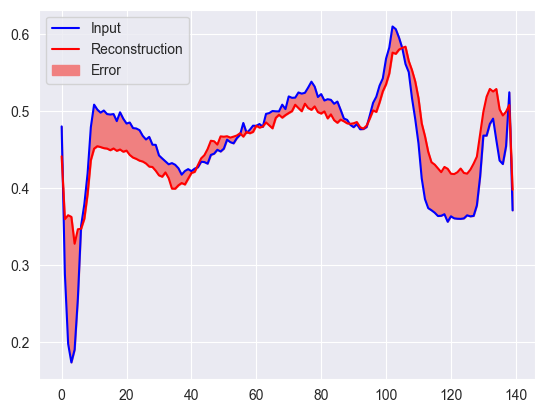

In [13]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()



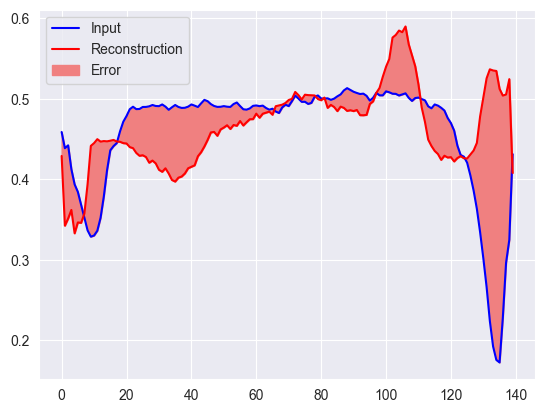

In [14]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[1], 'b')
plt.plot(decoded_data[1], 'r')
plt.fill_between(np.arange(140), decoded_data[1], anomalous_test_data[1], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


### Defining a Threshold

74/74 [==============================] - 0s 951us/step


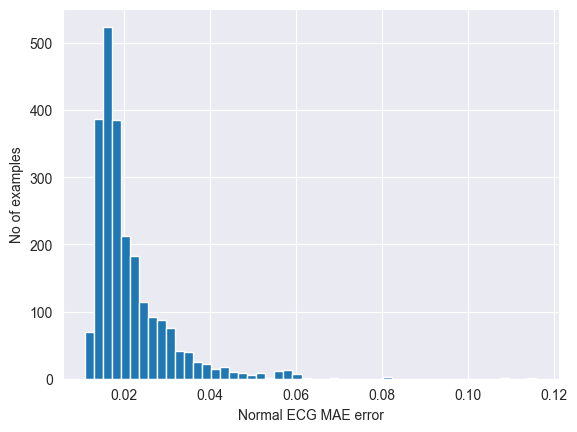

In [15]:
losses = []
labels = []

reconstructions = autoencoder.predict(normal_train_data)
normal_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

[losses.append(i) for i in normal_loss.numpy()]
[labels.append(1) for _ in normal_loss.numpy()]

plt.hist(normal_loss[None,:], bins=50)
plt.xlabel("Normal ECG MAE error")
plt.ylabel("No of examples")
plt.show()


14/14 [==============================] - 0s 2ms/step


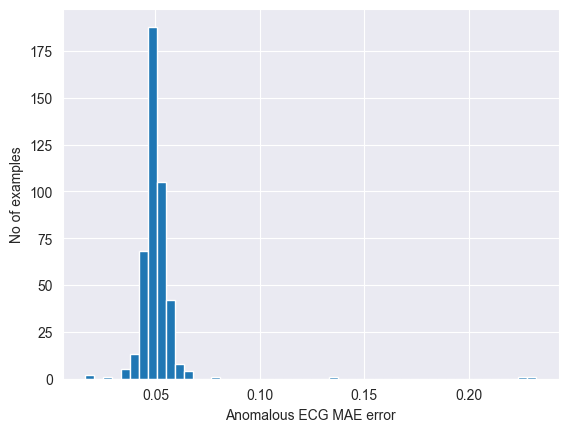

In [16]:
reconstructions = autoencoder.predict(anomalous_test_data)
anomalous_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

[losses.append(i) for i in anomalous_loss.numpy()]
[labels.append(0) for _ in anomalous_loss.numpy()]

plt.hist(anomalous_loss[None, :], bins=50)
plt.xlabel("Anomalous ECG MAE error")
plt.ylabel("No of examples")
plt.show()


(0.0, 0.1)

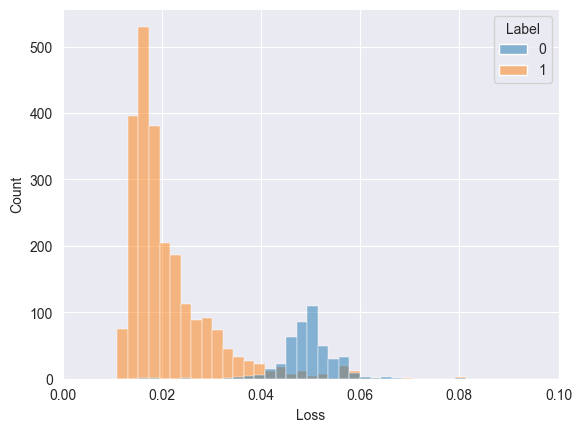

In [17]:
hist_data = pd.DataFrame({"Loss":losses, "Label":labels})
sns.histplot(data=hist_data, x="Loss", hue="Label")
plt.xlim(0, 0.1)

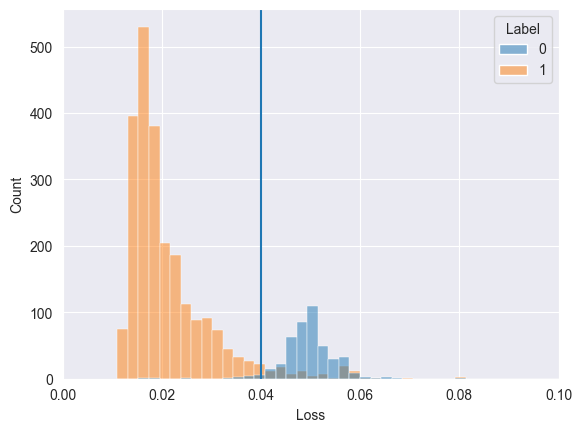

In [18]:
sns.histplot(data=hist_data, x="Loss", hue="Label")
plt.xlim(0, 0.1)
threshold = 0.04
plt.axvline(threshold)

Accuracy = 0.964
Precision = 0.976
Recall = 0.959
F1-Score = 0.968


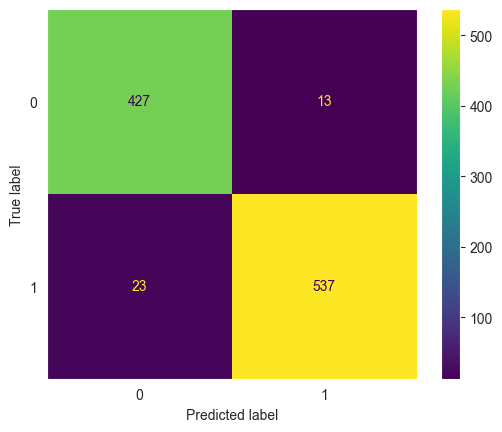

In [19]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print(f"Accuracy = {round(accuracy_score(labels, predictions),3)}")
  print(f"Precision = {round(precision_score(labels, predictions),3)}")
  print(f"Recall = {round(recall_score(labels, predictions),3)}")
  print(f"F1-Score = {round(f1_score(labels, predictions),3)}")
  
  cm = confusion_matrix(labels, predictions)
  disp = ConfusionMatrixDisplay(cm)
  disp.plot()
  plt.grid(False)

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)
